In [1]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [2]:
INPUT_DIR=r'{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master/DATASET'
OUTPUT_DIR =r'{PATH_HERE}/Divine-Vision-Deep-Learning-Based-Image-Caption-Generation-for-Indian-Deities-master/DATASET/Images'

In [3]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 [==============================] - 45s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [4]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/224 [00:00<?, ?it/s]

In [5]:
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [6]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [7]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [8]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/1120 [00:00<?, ?it/s]

Total number of captions: 1120


In [9]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [10]:
image_to_captions_mapping['image_1']

['God Brahma painting in sitting posture.',
 'Hindu deity brahma giving blessing .',
 'Lord Brahma painting with multiple heads and hands .',
 'God Brahma drawing wearing lots of jewellary .',
 'God Brahma portrait with white beared and moustache .']

In [11]:
clean(image_to_captions_mapping)

In [12]:
image_to_captions_mapping['image_1']

['startseq god brahma painting in sitting posture endseq',
 'startseq hindu deity brahma giving blessing endseq',
 'startseq lord brahma painting with multiple heads and hands endseq',
 'startseq god brahma drawing wearing lots of jewellary endseq',
 'startseq god brahma portrait with white beared and moustache endseq']

In [13]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [14]:
all_captions[:10]

['startseq god brahma painting in sitting posture endseq',
 'startseq hindu deity brahma giving blessing endseq',
 'startseq lord brahma painting with multiple heads and hands endseq',
 'startseq god brahma drawing wearing lots of jewellary endseq',
 'startseq god brahma portrait with white beared and moustache endseq',
 'startseq god brahma portrait of sitting on lotus endseq',
 'startseq lord brahma portraying sitting stance on lotus with four hands and three heads endseq',
 'startseq brahma is hindu deity with three heads endseq',
 'startseq all four hands of god brahma are occupied with some artifacts endseq',
 'startseq god brahma in sitting stance on pink lotus endseq']

In [15]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [16]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [17]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 789
Maximum Caption Length: 32


In [18]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [20]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# Set the number of epochs, batch size
epochs = 25
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/25
7/7 [==============================] - 16s 921ms/step - loss: 5.9898 - val_loss: 6.5766
Epoch 2/25
7/7 [==============================] - 3s 386ms/step - loss: 4.4028 - val_loss: 6.4881
Epoch 3/25
7/7 [==============================] - 3s 401ms/step - loss: 3.8932 - val_loss: 7.2990
Epoch 4/25
7/7 [==============================] - 3s 402ms/step - loss: 3.6163 - val_loss: 6.6203
Epoch 5/25
7/7 [==============================] - 3s 375ms/step - loss: 3.3833 - val_loss: 6.7094
Epoch 6/25
7/7 [==============================] - 3s 376ms/step - loss: 3.2150 - val_loss: 7.0230
Epoch 7/25
7/7 [==============================] - 3s 406ms/step - loss: 3.1751 - val_loss: 6.6018
Epoch 8/25
7/7 [==============================] - 3s 393ms/step - loss: 2.8948 - val_loss: 7.0821
Epoch 9/25
7/7 [==============================] - 3s 403ms/step - loss: 2.8517 - val_loss: 7.2958
Epoch 10/25
7/7 [==============================] - 3s 416ms/step - loss: 2.7225 - val_loss: 7.3794
Epoch 11/25
7/7 [=

In [22]:
model.save(OUTPUT_DIR+'/mymodel.h5')

In [23]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [24]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [25]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/23 [00:00<?, ?it/s]

BLEU-1: 0.328720
BLEU-2: 0.049715


In [26]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq god shiva standing posture holding trishul and white cow in background endseq
startseq shiva wearing lion skin with mountain background endseq
startseq deity shiva standing with cow endseq
startseq shiva with black hair bun and snake around his neck endseq
startseq lord shiva with white cow and holding trishul endseq
--------------------Predicted--------------------
startseq god brahma in of of jewellary endseq


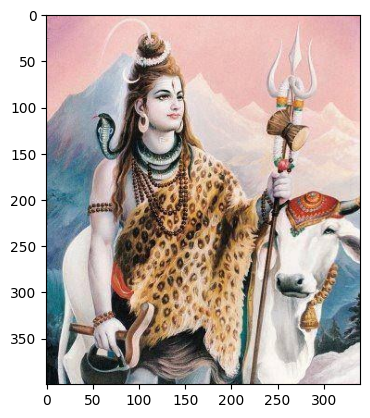

In [27]:
generate_caption("image_40.jpeg")

In [28]:
from tabulate import tabulate

# Initialize lists to store BLEU scores and loss values
bleu_1_scores = []
bleu_2_scores = []
loss_values = []

# ...

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    # Train the model for one epoch
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
                        validation_data=test_generator, validation_steps=validation_steps,
                        verbose=1)
    
    # Append loss value to the list
    loss_values.append(history.history['loss'][0])
    
    # ...

    # Evaluate BLEU scores after each epoch
    actual_captions_list = []
    predicted_captions_list = []

    for key in tqdm(test):
        actual_captions = image_to_captions_mapping[key]
        predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

        actual_captions_words = [caption.split() for caption in actual_captions]
        predicted_caption_words = predicted_caption.split()

        actual_captions_list.append(actual_captions_words)
        predicted_captions_list.append(predicted_caption_words)

    # Calculate BLEU-1 and BLEU-2 scores
    bleu_1 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0))
    
    # Append scores to the lists
    bleu_1_scores.append(bleu_1)
    bleu_2_scores.append(bleu_2)

    # Display the table after each epoch
    table = tabulate({'Epoch': [epoch + 1], 'Loss': [history.history['loss'][0]], 'BLEU-1': [bleu_1], 'BLEU-2': [bleu_2]}, headers='keys', tablefmt='pretty')
    print(table)


Epoch 1/25
7/7 [==============================] - 3s 382ms/step - loss: 1.2160 - val_loss: 10.1004


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+-------------------+---------------------+--------------------+
| Epoch |       Loss        |       BLEU-1        |       BLEU-2       |
+-------+-------------------+---------------------+--------------------+
|   1   | 1.215971827507019 | 0.34798534798534797 | 0.0373087307736593 |
+-------+-------------------+---------------------+--------------------+
Epoch 2/25
7/7 [==============================] - 3s 380ms/step - loss: 1.2664 - val_loss: 10.1459


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|   2   | 1.2663551568984985 | 0.3439567489708001 | 0.07904254025775835 |
+-------+--------------------+--------------------+---------------------+
Epoch 3/25
7/7 [==============================] - 3s 408ms/step - loss: 1.1751 - val_loss: 10.1722


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|   3   | 1.1751056909561157 | 0.3237410071942446 | 0.05038993108215829 |
+-------+--------------------+--------------------+---------------------+
Epoch 4/25
7/7 [==============================] - 3s 398ms/step - loss: 1.0342 - val_loss: 10.1976


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+----------------------+
| Epoch |        Loss        |       BLEU-1        |        BLEU-2        |
+-------+--------------------+---------------------+----------------------+
|   4   | 1.0342087745666504 | 0.36929460580912865 | 0.041158376465221316 |
+-------+--------------------+---------------------+----------------------+
Epoch 5/25
7/7 [==============================] - 2s 351ms/step - loss: 0.9586 - val_loss: 10.1595


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|   5   | 0.9585798978805542 | 0.3589743589743589 | 0.07578647467450735 |
+-------+--------------------+--------------------+---------------------+
Epoch 6/25
7/7 [==============================] - 2s 346ms/step - loss: 0.9495 - val_loss: 10.3981


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+------------------+--------------------+----------------------+
| Epoch |       Loss       |       BLEU-1       |        BLEU-2        |
+-------+------------------+--------------------+----------------------+
|   6   | 0.94951331615448 | 0.3036116351705317 | 0.056457820781778134 |
+-------+------------------+--------------------+----------------------+
Epoch 7/25
7/7 [==============================] - 3s 420ms/step - loss: 0.9027 - val_loss: 10.9090


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|   7   | 0.9027290940284729 | 0.33948339483394835 | 0.06408318008467982 |
+-------+--------------------+---------------------+---------------------+
Epoch 8/25
7/7 [==============================] - 3s 377ms/step - loss: 0.8060 - val_loss: 10.8789


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|   8   | 0.8060163259506226 | 0.33748966712566203 | 0.08417502228835326 |
+-------+--------------------+---------------------+---------------------+
Epoch 9/25
7/7 [==============================] - 3s 390ms/step - loss: 0.7165 - val_loss: 11.5286


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|   9   | 0.7164999842643738 | 0.3377049180327869 | 0.04893945586802189 |
+-------+--------------------+--------------------+---------------------+
Epoch 10/25
7/7 [==============================] - 5s 722ms/step - loss: 0.7606 - val_loss: 11.9160


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  10   | 0.7605628967285156 | 0.3445692883895131 | 0.06508846014566144 |
+-------+--------------------+--------------------+---------------------+
Epoch 11/25
7/7 [==============================] - 5s 720ms/step - loss: 0.7002 - val_loss: 12.0404


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  11   | 0.7002280354499817 | 0.34661354581673315 | 0.06753298860719976 |
+-------+--------------------+---------------------+---------------------+
Epoch 12/25
7/7 [==============================] - 4s 632ms/step - loss: 0.7749 - val_loss: 12.2120


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+----------------------+
| Epoch |        Loss        |       BLEU-1        |        BLEU-2        |
+-------+--------------------+---------------------+----------------------+
|  12   | 0.7748633623123169 | 0.33948339483394835 | 0.052323697434116814 |
+-------+--------------------+---------------------+----------------------+
Epoch 13/25
7/7 [==============================] - 4s 533ms/step - loss: 0.6617 - val_loss: 11.9746


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  13   | 0.6617298722267151 | 0.3426883642463121 | 0.07361857383743922 |
+-------+--------------------+--------------------+---------------------+
Epoch 14/25
7/7 [==============================] - 4s 533ms/step - loss: 0.6656 - val_loss: 11.5827


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  14   | 0.6656360030174255 | 0.3421052631578948 | 0.05306299254899105 |
+-------+--------------------+--------------------+---------------------+
Epoch 15/25
7/7 [==============================] - 3s 476ms/step - loss: 0.6214 - val_loss: 11.6901


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  15   | 0.6213959455490112 | 0.31507930870928413 | 0.04121629112652674 |
+-------+--------------------+---------------------+---------------------+
Epoch 16/25
7/7 [==============================] - 3s 468ms/step - loss: 0.6103 - val_loss: 11.8590


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  16   | 0.6103217005729675 | 0.33090909090909093 | 0.03623715376697394 |
+-------+--------------------+---------------------+---------------------+
Epoch 17/25
7/7 [==============================] - 6s 799ms/step - loss: 0.5335 - val_loss: 11.9885


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  17   | 0.5335268378257751 | 0.3326384083652352 | 0.05730497957108015 |
+-------+--------------------+--------------------+---------------------+
Epoch 18/25
7/7 [==============================] - 5s 735ms/step - loss: 0.5497 - val_loss: 12.7884


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  18   | 0.5497007966041565 | 0.33992094861660077 | 0.07688737654253174 |
+-------+--------------------+---------------------+---------------------+
Epoch 19/25
7/7 [==============================] - 5s 725ms/step - loss: 0.5077 - val_loss: 12.6248


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+----------------------+
| Epoch |        Loss        |       BLEU-1       |        BLEU-2        |
+-------+--------------------+--------------------+----------------------+
|  19   | 0.5076631307601929 | 0.3483606557377049 | 0.056147886156098836 |
+-------+--------------------+--------------------+----------------------+
Epoch 20/25
7/7 [==============================] - 5s 682ms/step - loss: 0.5046 - val_loss: 12.5264


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  20   | 0.5045970678329468 | 0.3629343629343629 | 0.06792328327004354 |
+-------+--------------------+--------------------+---------------------+
Epoch 21/25
7/7 [==============================] - 4s 627ms/step - loss: 0.4854 - val_loss: 12.7520


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+---------------------+--------------------+---------------------+
| Epoch |        Loss         |       BLEU-1       |       BLEU-2        |
+-------+---------------------+--------------------+---------------------+
|  21   | 0.48540112376213074 | 0.3751329498089383 | 0.07783687222281395 |
+-------+---------------------+--------------------+---------------------+
Epoch 22/25
7/7 [==============================] - 4s 596ms/step - loss: 0.5482 - val_loss: 13.3534


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  22   | 0.5482496023178101 | 0.3609022556390978 | 0.05450127462088585 |
+-------+--------------------+--------------------+---------------------+
Epoch 23/25
7/7 [==============================] - 4s 510ms/step - loss: 0.4519 - val_loss: 13.6763


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  23   | 0.4518526494503021 | 0.3689732919217371 | 0.07898337193604804 |
+-------+--------------------+--------------------+---------------------+
Epoch 24/25
7/7 [==============================] - 4s 536ms/step - loss: 0.3944 - val_loss: 13.5354


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+-----------------------+
| Epoch |        Loss        |       BLEU-1       |        BLEU-2         |
+-------+--------------------+--------------------+-----------------------+
|  24   | 0.3944268524646759 | 0.3590733590733591 | 8.93848278266802e-155 |
+-------+--------------------+--------------------+-----------------------+
Epoch 25/25
7/7 [==============================] - 6s 899ms/step - loss: 0.3811 - val_loss: 13.7139


  0%|          | 0/23 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  25   | 0.3810505270957947 | 0.3542700438016824 | 0.07608477548508515 |
+-------+--------------------+--------------------+---------------------+


In [33]:
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Initialize lists to store ROUGE scores
rouge1_scores = []
rougeL_scores = []

# Loop through the test data
for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Calculate ROUGE scores
    scores = rouge_scorer.score(' '.join(actual_captions), ' '.join(predicted_caption))
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 score:", avg_rouge1)
print("Average ROUGE-L score:", avg_rougeL)


  0%|          | 0/23 [00:00<?, ?it/s]

Average ROUGE-1 score: 0.10789488327474063
Average ROUGE-L score: 0.1045637984847018


In [32]:
from nltk.tokenize import word_tokenize

def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    caption_tokens = [caption]  # Initialize list to store tokens
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        caption_tokens.append(predicted_word)  # Append token to list
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption_tokens

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption_tokens = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Append pre-tokenized predicted caption tokens
    predicted_captions_list.append(predicted_caption_tokens)

    # Append to the lists
    actual_captions_list.append(actual_captions_words)

# Now you can calculate METEOR score
meteor_scores = []
for i in range(len(actual_captions_list)):
    meteor_scores.append(meteor_score(actual_captions_list[i], predicted_captions_list[i]))

# Calculate average METEOR score
avg_meteor = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR score:", avg_meteor)

  0%|          | 0/23 [00:00<?, ?it/s]

Average METEOR score: 0.18571695510758274
